# Basic Statistics Test on the Dataset

In [14]:
import pandas as pd
import numpy as np

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from matplotlib.backends.backend_pdf import PdfPages

In [18]:
alldata = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/full_cleaned_data.csv')

In [19]:
alldata['Agree'] = ~(alldata['True_state']^alldata['Alert'])

In [20]:
alldata.head()

,Trial,True_state,Alert,Identification,First_toggle_time,RMS,Attention,Click,Top_Left_Enemy,Top_Right_Enemy,Bottom_Left_Enemy,Bottom_Right_Enemy,Top_Left_Dark,Top_Right_Dark,Bottom_Left_Dark,Bottom_Right_Dark,Agree
0,0,True,True,True,4179,65.244487,0.914573,2,True,False,False,False,False,True,True,True,True
1,1,False,False,False,3653,67.293907,0.895000,2,False,False,False,False,True,True,True,True,True
2,2,False,True,False,2186,100.119892,0.854271,2,False,False,False,False,True,False,True,False,False
3,3,False,False,False,3412,33.403009,0.889447,2,False,False,False,False,True,False,True,True,True
4,4,False,False,False,4514,70.063858,0.929648,2,False,False,False,False,True,True,True,True,True


In [21]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
Trial                 4000 non-null int64
True_state            4000 non-null bool
Alert                 4000 non-null bool
Identification        4000 non-null bool
First_toggle_time     4000 non-null int64
RMS                   4000 non-null float64
Attention             4000 non-null float64
Click                 4000 non-null int64
Top_Left_Enemy        4000 non-null bool
Top_Right_Enemy       4000 non-null bool
Bottom_Left_Enemy     4000 non-null bool
Bottom_Right_Enemy    4000 non-null bool
Top_Left_Dark         4000 non-null bool
Top_Right_Dark        4000 non-null bool
Bottom_Left_Dark      4000 non-null bool
Bottom_Right_Dark     4000 non-null bool
Agree                 4000 non-null bool
dtypes: bool(12), float64(2), int64(3)
memory usage: 203.2 KB


In [46]:
a = np.percentile(alldata['RMS'],[0.25,0.75])

In [49]:
alldata.describe()

,Trial,First_toggle_time,RMS,Attention,Click
count,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000
mean,49.500000,1766.29700,31.970409,0.865357,3.209750
std,28.869679,2011.60818,14.044292,0.070546,1.929167
min,0.000000,3.00000,7.560722,0.537688,0.000000
25%,24.750000,713.75000,22.716055,0.824121,2.000000
50%,49.500000,1170.00000,29.018967,0.875000,2.000000
75%,74.250000,1939.25000,37.703007,0.918884,4.000000
max,99.000000,10000.00000,204.234375,1.000000,13.000000


In [91]:
abnormal = alldata[alldata['RMS']>60]
normal = alldata[alldata['RMS']<=60]

In [92]:
abnormal.shape

(160, 17)

In [43]:
len(normal)-sum(normal['Identification'])

2534

In [45]:
sum(abnormal['Identification'])

88

Next We try logistic regression, the first and the most simple machine learning model for binary outcomes.

In [93]:
newdata = abnormal.append(normal.sample(n=160,random_state=70))

In [94]:
newdata['performance'] = newdata['RMS'] <= 60

In [95]:
X = newdata.drop(['RMS','performance','Click'],axis=1)
y = newdata['performance']

In [96]:
accuracy = []
auc = []

In [97]:
states = np.arange(0,30)

In [98]:
for state in states:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state=state,stratify=y)
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    accuracy.append(np.sum(y_pred==y_test)/len(y_pred))
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    auc.append(roc_auc_score(y_test,y_pred_prob))

In [99]:
np.mean(accuracy)

0.6596354166666667

In [100]:
np.median(accuracy)

0.6640625

In [101]:
np.mean(auc)

0.6940999348958333

In [102]:
np.median(auc)

0.7061767578125

In [62]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
y_pred = logreg.predict(X_test)

In [64]:
print(confusion_matrix(y_test, y_pred))

[[28 36]
 [18 62]]


In [65]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.61      0.44      0.51        64
       True       0.63      0.78      0.70        80

avg / total       0.62      0.62      0.61       144



In [66]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

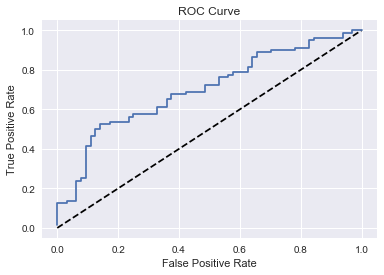

In [67]:
pp = PdfPages('Sample_ROC.pdf')
sns.set()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(pp,format='pdf')
pp.close()

In [68]:
print("AUC: {}".format(roc_auc_score(y_test,y_pred_prob)))

AUC: 0.6998046875
